In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
PARQUETS_PATH = 'results/'
TEST_START_DATE = '2023-08-20 17:00:00'
VALIDATION_START_DATE = '2023-08-20 12:00:00'

FEATURE_LIST = [
    #'previous_price_1min',
    'previous_price_5min',
    'previous_price_10min',
    'previous_price_15min',
    'previous_price_20min',
    'previous_price_25min',
    'previous_price_30min',
    'max_30min',
    'min_30min',
    'mean_30min'
]

In [4]:
data_df = pd.read_parquet(PARQUETS_PATH)
data_df

,time,open,high,low,close,volume
0,2023-08-19 03:01:53.180,26054.00,26059.91,26050.26,26058.01,1000
1,2023-08-19 03:03:00.005,26058.00,26059.91,26048.67,26058.00,1000
2,2023-08-19 03:05:09.229,26057.99,26072.86,26057.99,26072.01,1000
3,2023-08-19 03:07:59.999,26072.00,26077.09,26067.68,26077.09,1000
4,2023-08-19 03:11:15.691,26077.09,26080.20,26074.00,26078.26,1000
...,...,...,...,...,...,...
1063,2023-08-21 02:40:51.078,26169.87,26188.43,26169.86,26187.99,1000
1064,2023-08-21 02:46:36.503,26187.99,26188.77,26171.70,26171.70,1000
1065,2023-08-21 02:50:59.990,26171.70,26179.99,26168.00,26170.01,1000
1066,2023-08-21 02:56:09.506,26170.00,26188.88,26170.00,26188.87,1000


In [55]:
def add_feature(data_df):
    data_df['previous_price_1min'] = data_df['price'].shift(1)
    for i in range(1, 13):
        data_df[f'previous_price_{i*5}min'] = data_df['previous_price_1min'] - data_df['price'].shift(i*5)
        data_df['target'] = data_df['price'] - data_df['previous_price_1min']
    
    data_df['max_30min'] = data_df['target'].shift(1).rolling(window=6*5).max()
    data_df['min_30min'] = data_df['target'].shift(1).rolling(window=6*5).min()
    data_df['mean_30min'] = data_df['target'].shift(1).rolling(window=6*5).mean()
    return data_df

In [56]:
feature_df = add_feature(data_df)
feature_df.dropna(inplace=True)
feature_df

,time,price,previous_price_1min,previous_price_5min,target,previous_price_10min,previous_price_15min,previous_price_20min,previous_price_25min,previous_price_30min,previous_price_35min,previous_price_40min,previous_price_45min,previous_price_50min,previous_price_55min,previous_price_60min,max_30min,min_30min,mean_30min
60,2023-08-19 04:00:00,26099.09,26099.08,-12.59,0.01,-8.91,-40.34,23.00,53.78,81.40,68.85,50.37,29.39,20.40,26.23,45.08,47.61,-33.43,2.569333
61,2023-08-19 04:01:00,26092.47,26099.09,-8.91,-6.62,-10.91,-6.90,-0.14,45.22,77.45,71.06,53.96,33.28,20.08,27.49,48.83,47.61,-33.43,2.713667
62,2023-08-19 04:02:00,26099.98,26092.47,-8.46,7.51,-15.52,-25.65,-14.49,32.53,70.83,71.17,57.22,32.90,22.63,18.47,34.47,47.61,-33.43,2.361000
63,2023-08-19 04:03:00,26092.00,26099.98,3.98,-7.98,-28.95,-14.02,-54.59,25.19,57.98,76.79,71.01,40.41,30.15,22.90,41.98,47.61,-33.43,2.611333
64,2023-08-19 04:04:00,26089.31,26092.00,-7.08,-2.69,-28.07,-17.72,-48.18,17.22,48.01,70.00,61.78,36.93,23.55,16.00,29.09,47.61,-33.43,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2023-08-21 02:55:00,26179.98,26178.79,2.52,1.19,-7.21,-3.39,14.80,1.49,23.93,18.80,26.79,11.89,-2.72,-30.68,-31.76,12.01,-9.99,0.808000
2876,2023-08-21 02:56:00,26187.89,26179.98,9.98,7.91,3.97,-8.02,3.98,2.69,17.20,29.99,29.98,17.97,-0.96,-29.48,-29.48,12.01,-9.99,0.837333
2877,2023-08-21 02:57:00,26190.00,26187.89,12.38,2.11,19.89,-0.11,7.99,18.04,15.67,37.89,37.90,25.88,11.98,-0.12,-21.57,12.01,-9.99,0.837000
2878,2023-08-21 02:58:00,26189.99,26190.00,11.20,-0.01,21.99,1.23,8.06,29.07,12.70,36.01,27.26,30.01,20.18,3.86,-19.46,12.01,-9.99,0.592667


In [57]:
def train_test_splitting(dataset, split_date):

    train_df = dataset[dataset['time'] < split_date]
    test_df = dataset[dataset['time'] >= split_date]

    return train_df, test_df

In [58]:
train_df, test_df = train_test_splitting(feature_df, TEST_START_DATE)

In [59]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_START_DATE) 

In [60]:
print(f'train dataframe shape : {train_df.shape}')
print(f'train dataframe shape : {test_df.shape}')
print(f'train dataframe shape : {valid_df.shape}')
train_df.head()

train dataframe shape : (2220, 19)
train dataframe shape : (600, 19)
train dataframe shape : (300, 19)


,time,price,previous_price_1min,previous_price_5min,target,previous_price_10min,previous_price_15min,previous_price_20min,previous_price_25min,previous_price_30min,previous_price_35min,previous_price_40min,previous_price_45min,previous_price_50min,previous_price_55min,previous_price_60min,max_30min,min_30min,mean_30min
60,2023-08-19 04:00:00,26099.09,26099.08,-12.59,0.01,-8.91,-40.34,23.00,53.78,81.40,68.85,50.37,29.39,20.40,26.23,45.08,47.61,-33.43,2.569333
61,2023-08-19 04:01:00,26092.47,26099.09,-8.91,-6.62,-10.91,-6.90,-0.14,45.22,77.45,71.06,53.96,33.28,20.08,27.49,48.83,47.61,-33.43,2.713667
62,2023-08-19 04:02:00,26099.98,26092.47,-8.46,7.51,-15.52,-25.65,-14.49,32.53,70.83,71.17,57.22,32.90,22.63,18.47,34.47,47.61,-33.43,2.361000
63,2023-08-19 04:03:00,26092.00,26099.98,3.98,-7.98,-28.95,-14.02,-54.59,25.19,57.98,76.79,71.01,40.41,30.15,22.90,41.98,47.61,-33.43,2.611333
64,2023-08-19 04:04:00,26089.31,26092.00,-7.08,-2.69,-28.07,-17.72,-48.18,17.22,48.01,70.00,61.78,36.93,23.55,16.00,29.09,47.61,-33.43,1.666667


In [61]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', current_model)
        ])
        current_model.fit(train_df[feature_list], train_df['target'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['target'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [62]:
model = Ridge
best_params, best_score = grid_search(
    model, 
    {'alpha':[1, 10, 100, 1000, 1e4],
     },
    grid_search_train_df,
    valid_df, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 10000.0} 35.02721231880657


In [63]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['target'])

    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [64]:
base_model = Ridge(**best_params)
model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', base_model)
        ])

train_prediction_df , test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

In [65]:
def visualization(name, data, predicted_df):
    
    chunk_size = 300
    num_chunks = len(data) // chunk_size + 1

    plt.figure(figsize=(10, 6 * num_chunks))  # Adjust the figure size as needed

    for i in range(num_chunks):
        plt.subplot(num_chunks, 1, i + 1)  # Create subplots
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(data))

        plt.title(f'{name} - Part {i + 1}')
        plt.plot(range(start_idx, end_idx), data['target'][start_idx:end_idx])
        plt.plot(range(start_idx, end_idx), predicted_df[start_idx:end_idx])
        plt.legend(["Real Value", "Predicted"], loc="lower right")

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


C:\Users\bardia\AppData\Local\Temp\ipykernel_13328\3073756894.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(range(start_idx, end_idx), data['target'][start_idx:end_idx])


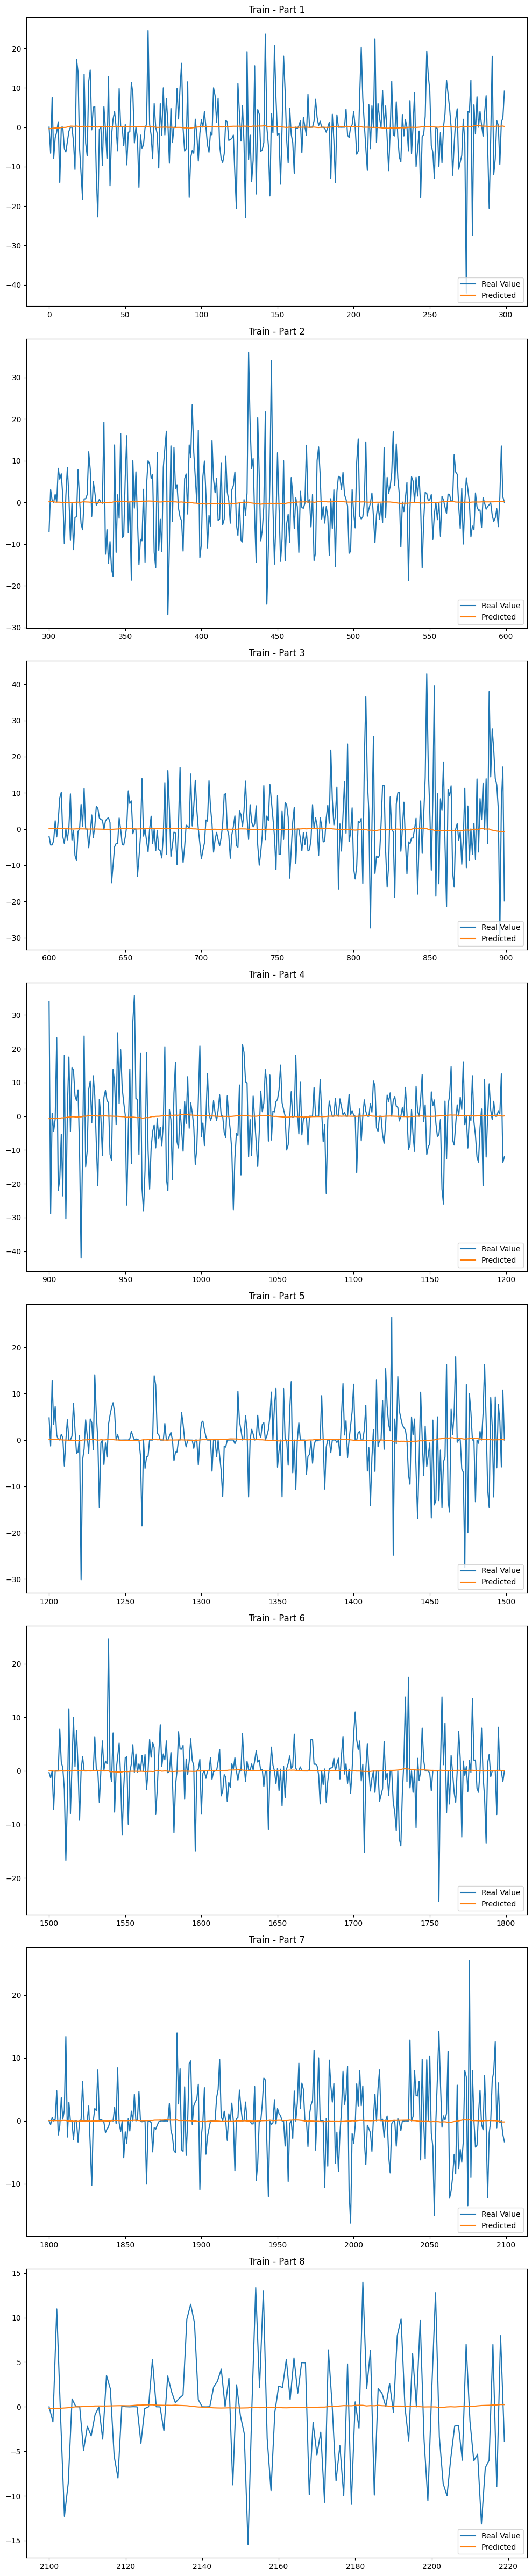

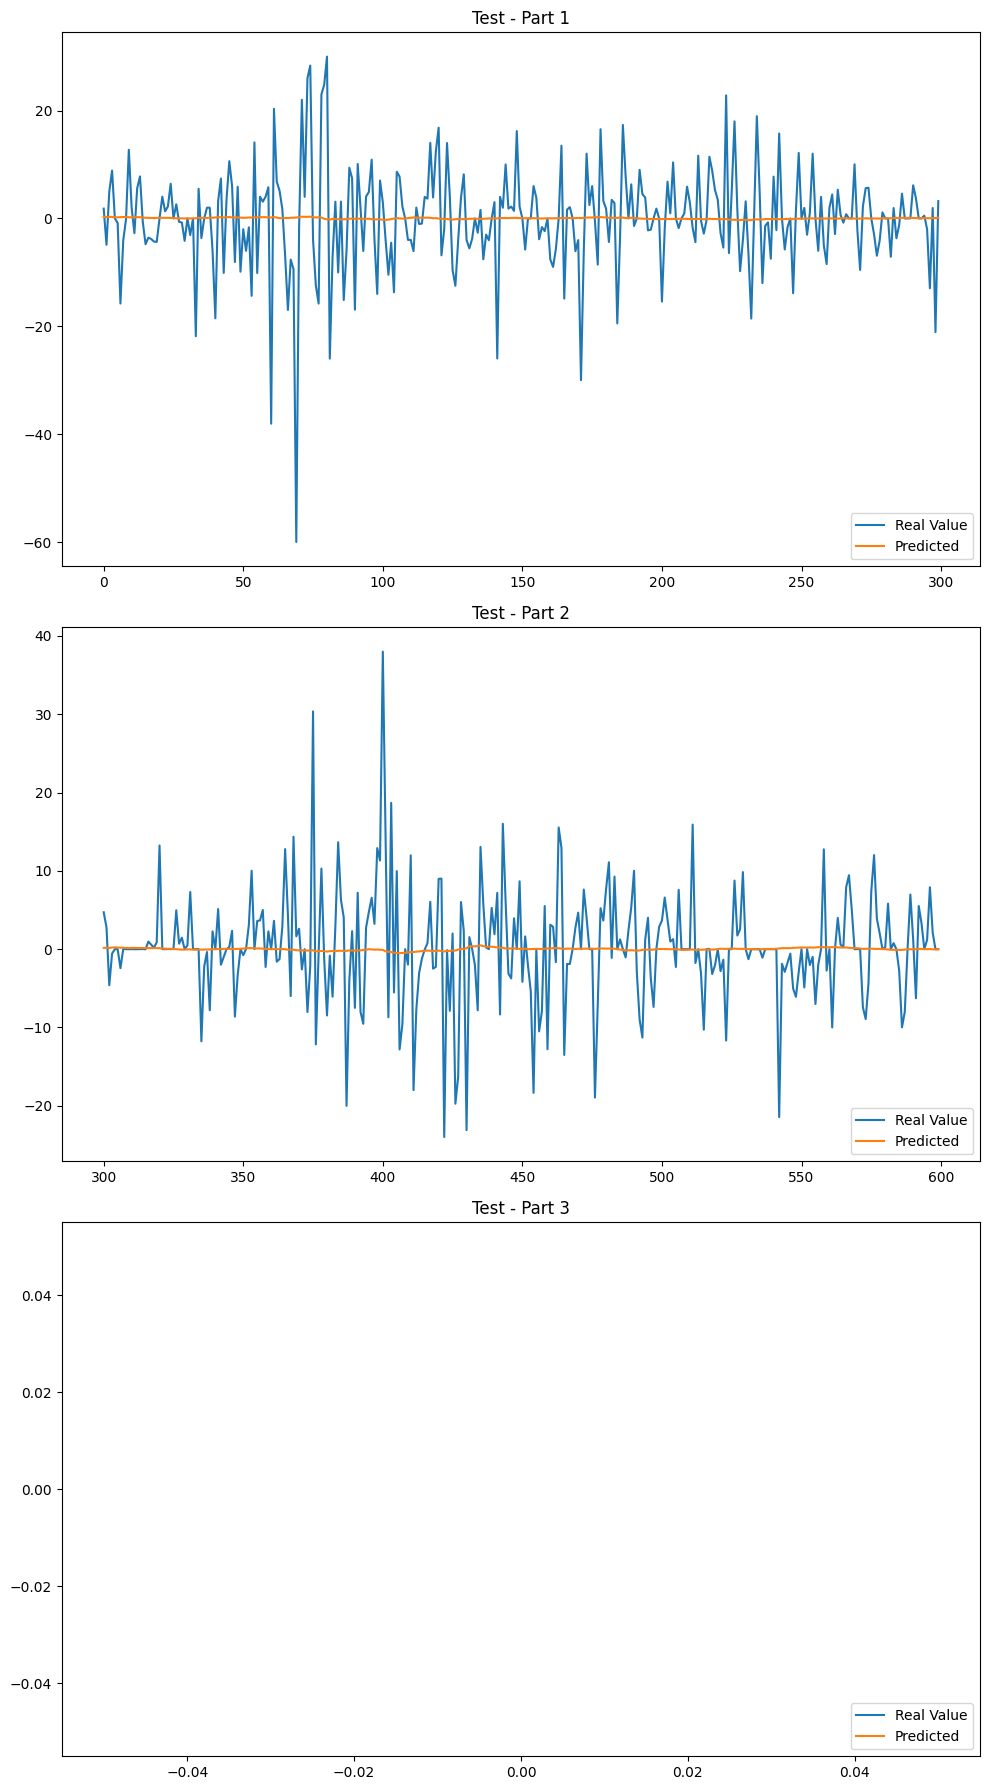

In [66]:
visualization('Train', train_df, train_prediction_df)
visualization('Test', test_df, test_prediction_df)

In [67]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [68]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_data['price'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['price'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['price'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['price'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['price'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['price'], test_prediction_df)


In [69]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 26047.733545045045
MSE : 678493082.7872618
MAPE : 0.999999390429886

Ridge Regression test scores:
MAE : 26135.735431913312
MSE : 683079307.7960936
MAPE : 0.9999995298664163
